In [1]:
from os import walk
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks_cwt
from scipy import constants

In [2]:
start_freq = 500e3
end_freq = 9e6

In [3]:
mu_null = 1.2566e-6
N = 80
R = 9e-2
b_i = lambda cur: cur * (mu_null * 8 *N / (math.sqrt(125) * R))

[ 893238.4341637  1403692.17081851 2091859.43060498 2798932.38434164
 4247108.54092527 4946619.21708185 5585631.67259786]


(4597.719323336908, -4714.966321547444, 6902.900465043267, -7020.756345385652)

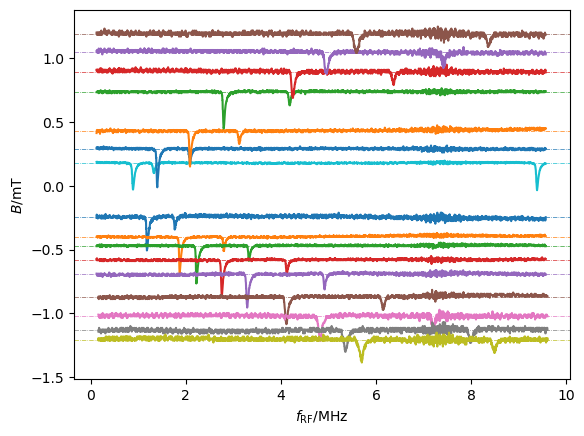

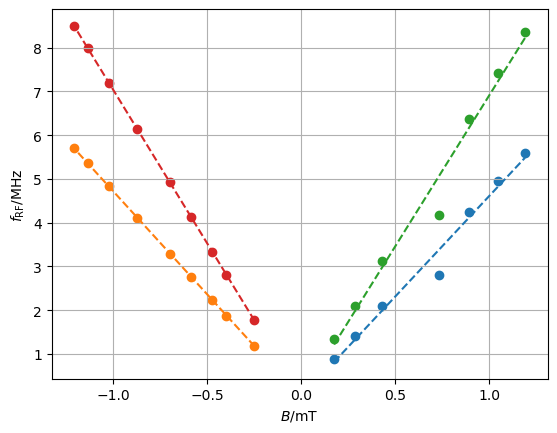

In [47]:
path = '../data/Frequenzmodulation'
filenames = next(walk(path))[2]
currents = []
zeeman_freqs_1 = []
zeeman_freqs_2 = []

fig1, ax1 = plt.subplots()
for i, filename in enumerate(filenames):
    color=next(ax1._get_lines.prop_cycler)['color']
    data = np.loadtxt(path + '/' + filename)
    current = float(filename.replace(',', '.'))
    currents.append(current)

    time = data[:,0]
    freq_trig = data[:,1]
    transmission = data[:,2]

    trigger_val = 1.5
    rising_trig = np.flatnonzero((freq_trig[:-1] < trigger_val) & (freq_trig[1:] > trigger_val)) + 1

    start_freq_modulation = time[rising_trig[0]]
    end_freq_modulation = time[rising_trig[1]]
    freq_time_slope = (end_freq - start_freq) /(end_freq_modulation - start_freq_modulation)

    calc_freq = lambda t: (t - start_freq_modulation) * freq_time_slope + start_freq

    ax1.plot(calc_freq(time) * 1e-6, ((transmission - transmission.mean()) / transmission.std())*0.2e-1 + b_i(current)*1e3, c=color)
    ax1.axhline(y = b_i(current)*1e3, linestyle = '-.', linewidth = '0.5', color=color)
    lowest_transmisstion_peaks = find_peaks_cwt(-transmission, widths=5)
    lowest_two_transmission_peak_freqs = calc_freq(time[lowest_transmisstion_peaks[(transmission[lowest_transmisstion_peaks]).argsort()[:2]]])

    zeeman_freqs_1.append(lowest_two_transmission_peak_freqs[0])
    zeeman_freqs_2.append(lowest_two_transmission_peak_freqs[1])

ax1.set(ylabel='$B / \mathrm{mT}$', xlabel='$f_\mathrm{RF} / \mathrm{MHz}$')
fig1.savefig('../output/overview_freq_modulation.svg')
fig, ax = plt.subplots()

currents = np.array(currents)
zeeman_freqs_1 = np.array(zeeman_freqs_1)
zeeman_freqs_2 = np.array(zeeman_freqs_2)

print(zeeman_freqs_1[currents>0])
slope_1, intercept_1, r_1, p_1, std_err_1 = stats.linregress(b_i(currents[currents > 0]),  np.array(zeeman_freqs_1[currents > 0])  * 1e-6)
slope_2, intercept_2, r_2, p_2, std_err_2 = stats.linregress(b_i(currents[currents < 0]),  np.array(zeeman_freqs_1[currents < 0])  * 1e-6)
slope_3, intercept_3, r_3, p_3, std_err_3 = stats.linregress(b_i(currents[currents > 0]),  np.array(zeeman_freqs_2[currents > 0])  * 1e-6)
slope_4, intercept_4, r_4, p_4, std_err_4 = stats.linregress(b_i(currents[currents < 0]),  np.array(zeeman_freqs_2[currents < 0])  * 1e-6)

ax.plot(b_i(currents[currents > 0])*1e3, slope_1 * b_i(currents[currents > 0]) + intercept_1, '--')
ax.scatter(b_i(currents[currents > 0])*1e3, np.array(zeeman_freqs_1[currents > 0])  * 1e-6)

ax.plot(b_i(currents[currents < 0])*1e3, slope_2 * b_i(currents[currents < 0]) + intercept_2, '--')
ax.scatter(b_i(currents[currents < 0])*1e3, np.array(zeeman_freqs_1[currents < 0])  * 1e-6)

ax.plot(b_i(currents[currents > 0])*1e3, slope_3 * b_i(currents[currents > 0]) + intercept_3, '--')
ax.scatter(b_i(currents[currents > 0])*1e3, np.array(zeeman_freqs_2[currents > 0])  * 1e-6)
ax.plot(b_i(currents[currents < 0])*1e3, slope_4 * b_i(currents[currents < 0]) + intercept_4, '--')
ax.scatter(b_i(currents[currents < 0])*1e3, np.array(zeeman_freqs_2[currents < 0])  * 1e-6)

ax.set(xlabel='$B / \mathrm{mT}$', ylabel='$f_\mathrm{RF} / \mathrm{MHz}$')

ax.grid()
fig.savefig('../output/lin_reg_freq_modulation.svg')
slope_1, slope_2, slope_3, slope_4

In [5]:
mu_b, _, _ = constants.physical_constants['Bohr magneton']
gf = lambda a : constants.h * a / mu_b

In [46]:
np.array((gf(slope_1), gf(slope_2), gf(slope_3), gf(slope_4))) * 1e6

array([ 0.32849663, -0.33687366,  0.4931966 , -0.50161714])